In [23]:
import numpy as np
import matplotlib.pyplot as plt
from rikabplotlib.plot_utils import newplot

# Constants
C_F = 4/3           # Casimir factor for fundamental representation
C_A = 3             # Casimir factor for adjoint representation
T_R = 1/2           # Trace normalization
n_f = 5             # Number of active quark flavors (e.g., n_f=5 for energies above bottom quark mass)
Lambda_QCD = 0.2    # QCD scale parameter in GeV

# Define the one-loop running of alpha_s
def alpha_s(Q, Lambda=Lambda_QCD, n_f=n_f):
    
    return (12*np.pi)/( (33 - 2*n_f)*np.log(Q**2 / Lambda**2) )




R = 1


def sample_weighted_x_NLO(N = 1000):

    Q = 500
    theta1 = np.random.uniform(0, R, N)
    theta2 = np.random.uniform(0, R, N)
    z1 = np.random.uniform(0, 1, N)
    z2 = np.random.uniform(0, 1, N)

    x = (z1 * theta1 + z2 * theta2) / R

    # ########## Integral 1 ##########

    const = (alpha_s(Q * x) * C_F / (2 * np.pi))**2
    symmetry_factor = 1/2
    Theta1 = (theta1 > theta2) * np.ones(N)
    Theta2 = (0.5 - z2 > 0) * np.ones(N)
    Theta3 = (1 - 2*z1 - z2 > 0) * np.ones(N)
    weight_1 = const * symmetry_factor * (1/theta1) * (1/theta2) * (1/z1) * (1/z2) * Theta1 * Theta2 * Theta3 



    # ########## Integral 2 ##########

    const = C_F * C_A * (alpha_s(Q * x)  / (2 * np.pi))**2
    symmetry_factor = 2

    zg = z1 + z2
    zprime = z2 / zg
    phi = np.random.uniform(0, 2*np.pi, N)
    theta_prime = (theta1 - theta2)/ np.sin(phi)

    Theta1 = (theta1 > theta2) * np.ones(N)
    Theta2 = (0.5 - zg > 0) * np.ones(N)
    Theta3 = (1 - zprime*zg > 0) * np.ones(N)
    weight_2 = const * symmetry_factor * (1/theta1) * (1/theta_prime) * (1/z1) * (1/z2) * Theta1 * Theta2 * Theta3


    return x, weight_1 + weight_2

def sample_weighted_x_LO(N = 1000):

    Q = 500
    theta1 = np.random.uniform(0, R, N)
    z1 = np.random.uniform(0, 1, N)

    x = (z1 * theta1) / R

    # ########## Integral 1 ##########

    const = (alpha_s(Q * x) * C_F / (2 * np.pi))
    symmetry_factor = 1
    Theta2 = (0.5 - z1 > 0) * np.ones(N)
    weight_1 = const * symmetry_factor * (1/theta1) * (1/z1) * Theta2


    return x, weight_1 




(1000000, 2) (1000000, 2)


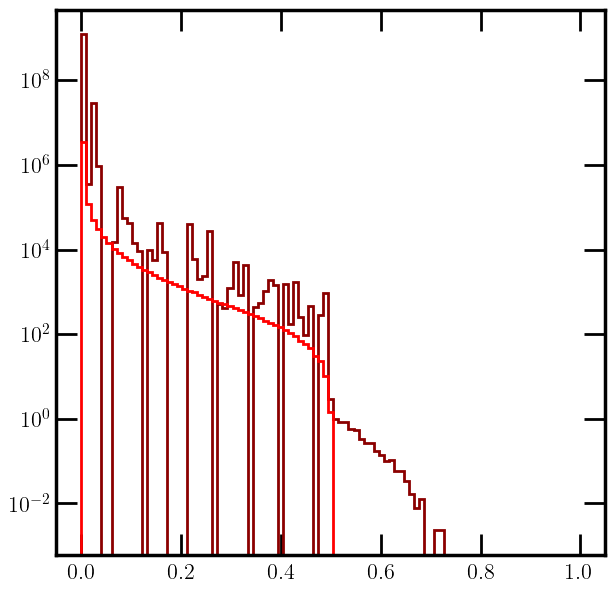

In [32]:
x_LO, w_LO = sample_weighted_x_LO(N = 1000000)
x_NLO, w_NLO = sample_weighted_x_NLO(N = 1000000)

fig, ax = newplot("full")


x_stacked = np.array([x_LO, x_NLO]).T
w_stacked = np.array([w_LO, w_NLO]).T

print(x_stacked.shape, w_stacked.shape)

# Stacked histogram
bins = np.linspace(0, 1, 100)
ax.hist(x_stacked, bins = bins, weights = w_stacked, histtype='bar', color=["red", "darkred"], label='LO+NLO', lw=2, stacked=True)
plt.yscale('log')


0.0


/tmp/ipykernel_140688/2072814962.py:104: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(bottom=0)


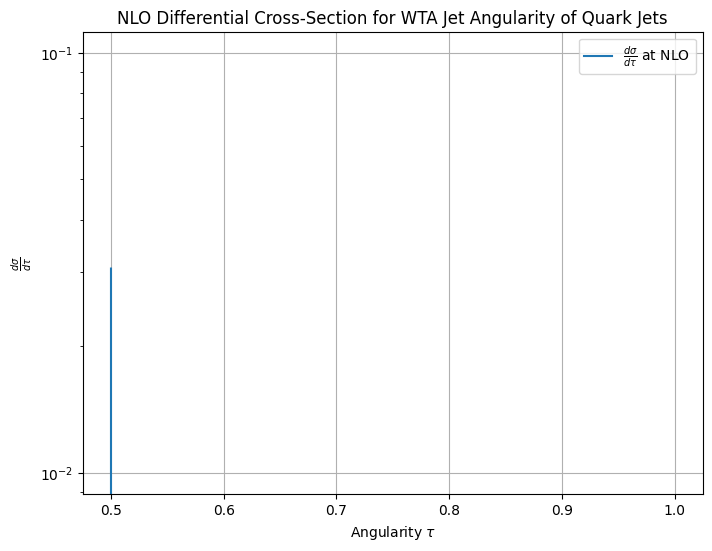

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import spence
import warnings

# Suppress warnings for invalid operations (e.g., log of negative numbers)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Define Constants
alpha_s = 0.118       # Example value for strong coupling constant
C_F = 4/3             # Casimir factor for fundamental representation in SU(3)
pi = np.pi            # Pi constant
R = 1.0               # Jet radius (set to 1 for simplicity)

# Define the Dilogarithm Function Li2(z)
def Li2(z):
    """
    Compute the dilogarithm function Li2(z).
    For z <= 1, use Li2(z) = -spence(1 - z)
    For z > 1, use the analytic continuation:
    Li2(z) = pi^2/3 - (ln z)^2 / 2 - (ln z) * pi*i - Li2(1/z)
    However, for real arguments and z >1, we can use the relation:
    Li2(z) = pi^2/3 - (ln z)^2 /2 - Li2(1/z)
    """
    z = np.array(z)
    Li2_z = np.zeros_like(z, dtype=np.float64)
    
    # For z <=1
    mask1 = z <=1
    Li2_z[mask1] = -spence(1 - z[mask1])
    
    # For z >1
    mask2 = z >1
    # Using the relation Li2(z) = pi^2/3 - (ln z)^2 /2 - Li2(1/z)
    Li2_z[mask2] = (pi**2)/3 - (np.log(z[mask2])**2)/2 - (-spence(1 - 1/z[mask2]))
    
    return Li2_z

# Define the Differential Cross-Section Function
def dSigmaDtau(x, alpha_s, C_F, pi, R):
    """
    Compute the differential cross-section dσ/dτ at NLO for WTA jet angularity.
    
    Parameters:
    x (float or ndarray): Angularity variable τ (must be <= 0.5)
    alpha_s (float): Strong coupling constant
    C_F (float): Casimir factor
    pi (float): Pi constant
    R (float): Jet radius
    
    Returns:
    float or ndarray: Differential cross-section dσ/dτ
    """
    x = np.array(x)
    
    # Initialize the result array
    result = np.zeros_like(x)
    
    # Define the valid domain: 0 < x <= 0.5
    valid = (x > 0) & (x <= 0.5)
    
    # Compute Li2(1/2) and constants
    Li2_1_2 = Li2(0.5)  # Li2(1/2)
    pi_sq_over_24 = (7 * pi**2) / 24  # 7 pi^2 /24
    
    # Compute Li2(1/(2x)) only for valid x
    Li2_1_over_2x = Li2(1/(2 * x[valid]))
    
    # Compute all terms inside the brackets
    term1 = pi_sq_over_24
    term2 = -Li2_1_2
    term3 = -Li2_1_over_2x
    term4 = (np.log(2)) / (2 * x[valid])
    term5 = 1 / (2 * x[valid])
    term6 = np.log(x[valid])
    
    # Sum all terms
    bracket = term1 + term2 + term3 + term4 + term5 + term6
    
    # Compute the differential cross-section
    result[valid] = (alpha_s * C_F / pi)**2 * (1 / (R * x[valid])) * bracket
    
    return result

# Define the range of x (tau)
x_values = np.linspace(0.5, 1.0, 500)  # Avoid x=0 to prevent division by zero

# Compute dσ/dτ for each x
dSigma_values = dSigmaDtau(x_values, alpha_s, C_F, pi, R)

print(dSigmaDtau(0.5001, alpha_s, C_F, pi, R))


# Plotting
plt.figure(figsize=(8,6))
plt.plot(x_values, dSigma_values, label=r'$\frac{d\sigma}{d\tau}$ at NLO')
plt.xlabel(r'Angularity $\tau$')
plt.ylabel(r'$\frac{d\sigma}{d\tau}$')
plt.title('NLO Differential Cross-Section for WTA Jet Angularity of Quark Jets')
plt.legend()
plt.grid(True)
plt.yscale('log')
# plt.xlim(0, 1.0)
plt.ylim(bottom=0)
plt.show()


/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/scipy/integrate/_quadpack_py.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


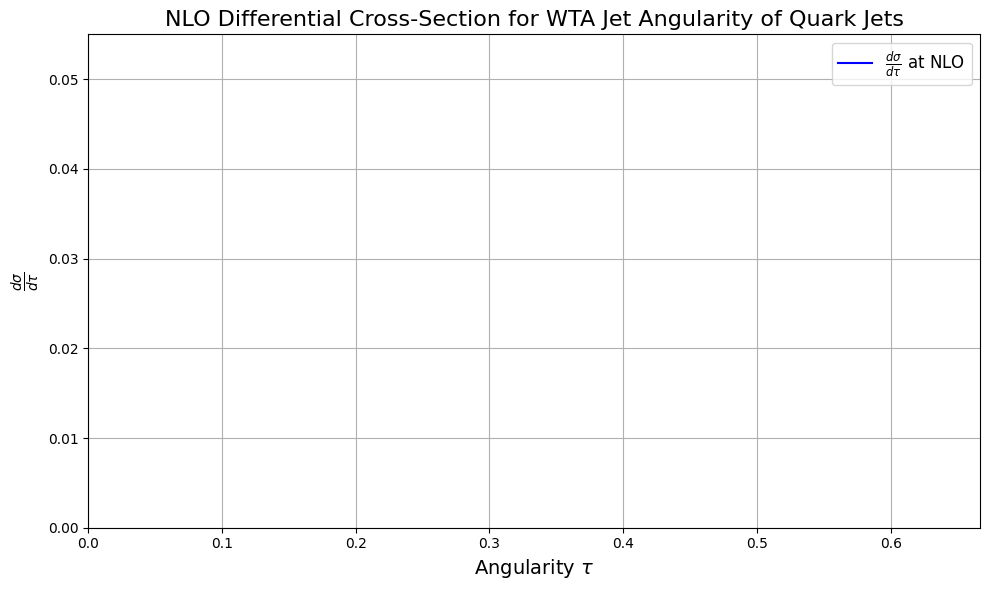

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import dblquad
from scipy.special import spence
import warnings

# Suppress warnings for invalid operations (e.g., log of zero or negative numbers)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Define Constants
alpha_s = 0.118          # Strong coupling constant
C_F = 4/3                # Casimir factor for fundamental representation in SU(3)
pi_val = np.pi           # Pi constant
R = 1.0                  # Jet radius (set to 1 for simplicity)

# Define the Integrand Function
def integrand(z2, z1, x):
    """
    Compute the integrand for the double integral over z1 and z2.

    Parameters:
    z2 (float): Momentum fraction z2
    z1 (float): Momentum fraction z1
    x (float): Angularity variable tau

    Returns:
    float: Value of the integrand
    """
    # Ensure that z1 + z2 > x to keep the argument of the logarithm positive
    if (z1 + z2) <= x:
        return 0.0

    term1 = np.log(z1 + z2) - np.log(z1)
    term2 = np.log(1 - x / (z1 + z2)) - np.log(1 - x / z1)
    
    return term1 + term2

# Define the Differential Cross-Section Function
def dSigmaDtau(x):
    """
    Compute the differential cross-section dσ/dτ for a given tau.

    Parameters:
    x (float): Angularity variable tau

    Returns:
    float: Differential cross-section dσ/dtau
    """
    # Define the limits for z1 and z2
    # z1 ranges from x to 1
    # For each z1, z2 ranges from 0 to (1 - z1)/2
    def z2_upper(z1):
        return (1 - z1) / 2

    def z2_lower(z1):
        return 0.0

    # Define the integrand for dblquad (order: z2, z1)
    def integrand_dbl(z1, z2):
        return integrand(z2, z1, x)

    # Perform the double integral using dblquad
    # dblquad integrates in the order: inner (z2), outer (z1)
    integral, error = dblquad(
        lambda z1, z2: integrand(z2, z1, x),
        x, 1.0,                     # Outer integral limits for z1
        lambda z1: 0.0,            # Lower limit for z2
        lambda z1: (1 - z1) / 2    # Upper limit for z2
    )

    # Compute the differential cross-section
    dSigma = (alpha_s * C_F / pi_val)**2 * (1 / (R * x)) * integral

    return dSigma

# Define the range of x (tau)
x_values = np.linspace(0.01, 2/3, 300)  # Avoid x=0 to prevent division by zero

# Compute dσ/dτ for each x
dSigma_values = []
for x in x_values:
    # To handle cases where z1 + z2 <=x, the integrand returns 0, so the integral is finite
    dSigma = dSigmaDtau(x)
    dSigma_values.append(dSigma)

dSigma_values = np.array(dSigma_values)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_values, dSigma_values, label=r'$\frac{d\sigma}{d\tau}$ at NLO', color='blue')
plt.xlabel(r'Angularity $\tau$', fontsize=14)
plt.ylabel(r'$\frac{d\sigma}{d\tau}$', fontsize=14)
plt.title('NLO Differential Cross-Section for WTA Jet Angularity of Quark Jets', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.xlim(0, 2/3)
plt.ylim(bottom=0)
plt.tight_layout()
plt.show()


In [17]:
print(dSigma_values)

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan na